## Fundamentals of Social Data Science: Week 1, Day 2

# Working with two distributions at the same time

One distribution is not very interesting generally, and its shape rarely tests to correspond to a specific ideal distribution. However, measurements of one kind can often relate to measurements of another kind. The fact that one set of measurements can help us understand another set of measurements is one of the central ways in which we make claims in science. 

Below are some key distinctions when using two measurements: 
1. Do they come from the same sample (paired) or come from different samples (independent)?
2. Are the measurements continuous, counts, or categories? 

Measurements of numeric data can be considered in many different ways, such as 'is the number divisible'? (i.e., its always strange to hear the average family "having 1.4 children"), is zero a real number (i.e. can one have an IQ of zero?), are negative values allowed (what would -3 kilmometres away mean?). It's not possible to cover all the possible combinations herein, but we can look at a few key ways in which we compare data. 

To determine whether two variables have information about each other tends to involve a bevy of statistical tests as well as considerable exploratory data. It is on the way to building complex models, but this firm foundation is still essential.

In this lab, we will again start with the Iris data, but this time we will want to look at the relationships between variables. Again, we will want to start with a consideration of distributions since they will make a difference to what tests we can use. 

Below we will 
- Start with a means comparison test that compares two groups. (independent samples t-test)
- Show both the formula and a function to do this in Python
- then show a generalisation of this test across multiple groups (admittedly just three in this case) via One-way ANOVA
- Explore bivariate data through visualisations and stats:
  - first by using a pairplot that includes several subplots,
  - then by looking at pairwise comparisons,
  - then looking at how parametric versus non-parametric pairwise comparisons makes a difference. 
- Finally, we will look at comparisons between multiple categories which we will assess using a chi-square test of indpendence. 

In all cases, we should be mindful of the difference between "expected" and "observed". The expected value is the one that we would expect to get if the distribution conformed to some stated function. The observed values are the ones we actually have or measure. When the expected and the observed values differ we would say that we have some form of 'loss'. If we have a little loss that means that we have a function that can help characterise the data. If we have a lot of loss that means that the function does not really help explain the data. There is no strict cut off for how much loss is too much, but generally we want to minimise our loss where possible. The important aspect of loss is that it helps us calibrate the strength of our claims: a very lossy model does not warrant very strong claims. Loosely speaking, the opposite of loss is "goodness of fit" or explanatory power. This means we can characterise a complex or heterogenous set of data with a simpler set of functions or measurements. While we will be using different measurements for goodness of fit or conversely for loss, such as R-squared, Pearson's r, or later on notions of precision and recall, this general principle remains broadly applicable. 

Then we will again return to the Stack Exchange Movies data and get you started on comparing the data there. 



In [2]:
# Update your Python to include Seaborn: 
# Activate your virtual environment in a terminal with source .venv/bin/activate
# Then run the following in the terminal: 
# pip install seaborn && pip freeze > requirements.txt
# same for statsmodels
# pip install statsmodels && pip freeze > requirements.txt
# This will install seaborn and add it to our requirements.txt
# You may also need Jinja2:
# pip install Jinja2 && pip freeze > requirements.txt

import seaborn as sns
%config InlineBackend.figure_format = 'svg'

# Set the style and color palette
sns.set_style("whitegrid")
sns.set_palette("husl")

from scipy import stats
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt


# Means comparison test: The t-test

We begin with the t-test. This is a simple test that uses the mean, N, and variance of a distribution to assess whether information about one distribution can help us understand information about another distribution. 

For example, in our three kinds of flowers, the average sepal length might be the same across the different species. If the mean is 3.1cm for one type of flower and 3.3 for another type of flower, we might say that the second flower is on average longer. But is .2cm difference really enough of a difference to say that one flower is longer than than the other? The t-test relies not just on the mean value, but also on the variance and the N (i.e. the sample size). 

Below I will first report the mean and standard deviation for sepal length for each flower. I will first show this as text and then I will show this visualised using _error bars_. Error bars let us know whether most of the flowers are clustered around the mean (i.e. high kurtosis) or whether the flowers have a mean value but actually have a really high level of variability. They are a simple tool, and later we will see visualisations that more fully represent the distribution (such as a boxplot), but conceptually error bars are useful and often available in even very small diagrams.


In [3]:
# Load the iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# Calculate mean and standard deviation for all flowers
all_flowers_stats = iris_df.describe()
all_flowers_stats.style.format('{:.2f}')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


The function `describe()` reports in Python some key descriptive statistics for all variables in the data. Also, this is its own DataFrame, so we can now reference this new DataFrame to access the means and standard deviations from the data.


In this case, we can see that the mean sepal width was 3.1cm and the standard deviation is 0.44cm. If this data is normally distributed (which we tend to think it is following the last walkthrough), then that means that roughly 34% of the flowers are between 2.66cm (i.e. 3.1-.44) and 3.1. Another 34% are between 3.1 and 3.55. But is this the case for each of the species? 

At present, we have not learned about grouping and aggregation functions, which we will see more in the next lecture. Those can be very useful for these operations, but instead of showing them now, let's use the tools that we have on hand. 

In [4]:
setosa_mask = iris_df["species"] == 'setosa'
setosa_view = iris_df[setosa_mask]

setosa_view.describe().style.format('{:.2f}')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,50.00,50.00,50.00,50.00
mean,5.01,3.43,1.46,0.25
std,0.35,0.38,0.17,0.11
min,4.30,2.30,1.00,0.10
25%,4.80,3.20,1.40,0.20
50%,5.00,3.40,1.50,0.20
75%,5.20,3.68,1.58,0.30
max,5.80,4.40,1.90,0.60


In [5]:
versicolor_mask = iris_df["species"] == 'versicolor'
versicolor_view = iris_df[versicolor_mask]

versicolor_view.describe().style.format('{:.2f}')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,50.00,50.00,50.00,50.00
mean,5.94,2.77,4.26,1.33
std,0.52,0.31,0.47,0.20
min,4.90,2.00,3.00,1.00
25%,5.60,2.52,4.00,1.20
50%,5.90,2.80,4.35,1.30
75%,6.30,3.00,4.60,1.50
max,7.00,3.40,5.10,1.80


It would seem simply looking at the table that while the the overall distribution seems normal, it contains within it at least two distributions which have relatively different means. Setosa is around 3.4cm and versicolour is around 2.8cm. So maybe they are drawn from different distributions, but instead of simply eyeballing it, we can check for ourselves with a t-test. 

Below we will see that the t-test really does just need the three numbers that I suggested above. We can test this by comparing the values from the t-test from Python with a hand-calculated formula. 

The formula for an indepedent samples t-test with unequal variances: (note we are not assuming the variance between the two samples is equal without any reason to, if we did, we might use a different test):

$$
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

The formula shows that we take the difference in means and then divide by the difference in standard deviations (divided by the number of samples for each group). 

With the t-score, we look this up on a t-distribution to get our p-value. Normally one does this algorithmically or even with a small table of values, but we can also do this using some formulae. I use the following formula for getting the "Degrees of Freedom":

$$
\nu \approx \frac{(s_1^2/n_1 + s_2^2/n_2)^2}{(s_1^2/n_1)^2/(n_1-1) + (s_2^2/n_2)^2/(n_2-1)} 
$$

This is a complicated formula. It's the Welch-Satterthwaite equation for unequal variances and not one I would normally remember by hand. The classic degrees of freedom is simply:

$$ 
df = n_1 + n_2 - 2 
$$ 

But unfortunately, this will assume equal variances which we are not assuming in this case. This makes the test a little more conservative but that's not a bad thing in this case - we want to really be sure that these are similar distributions. 

Then with the t-score and the degrees of freedom, we can get a p-value. 

It's a lot of work and I won't be doing this for all the various tests, but I wanted to highlight how many of these tests work not with the values directly but with some summarisation from these values. 

In the end, however, you'll almost certainly be using `scikit-learn` or `scipy` for these statistics. But importantly, you can see baked into these tests are a number of assumptions about the shape of the variable and how we can make use of it effectively. 

Thus, I compare this below to the independent samples t-test from scikit-learn. Notice that there's barely any difference. But the important point is that we did not need to take into account many variables or measurements in our data, only the average value (the mean), how spread out are the values around the mean (the standard deviation), and how many samples. 

In [6]:
feature = 'sepal length (cm)'

# Extract data for the two species
data1 = iris_df[setosa_mask][feature]
data2 = iris_df[versicolor_mask][feature]

# Calculate statistics
mean1, std1, n1 = data1.mean(), data1.std(), len(data1)
mean2, std2, n2 = data2.mean(), data2.std(), len(data2)

# Calculate t-statistic by hand
pooled_se = np.sqrt(std1**2/n1 + std2**2/n2)
t_stat = (mean1 - mean2) / pooled_se

# Calculate degrees of freedom (df) using Welch–Satterthwaite equation
df = (std1**2/n1 + std2**2/n2)**2 / ((std1**2/n1)**2/(n1-1) + (std2**2/n2)**2/(n2-1))

# Calculate p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

print(f"Manual t-test results:")
print(f"t-statistic: {t_stat:0.3f}")
print(f"p-value: {p_value:0.3f}")

# Perform t-test using scipy n
t_stat_scipy, p_value_scipy = stats.ttest_ind(data1, data2, equal_var=False)

print(f"\nscipy t-test results:")
print(f"t-statistic: {t_stat_scipy:0.3f}")
print(f"p-value: {p_value_scipy:0.3f}")

# Compare results
print(f"\nDifference in t-statistic: {abs(t_stat - t_stat_scipy):0.3f}")
print(f"Difference in p-value: {abs(p_value - p_value_scipy):.3e}")

Manual t-test results:
t-statistic: -10.521
p-value: 0.000

scipy t-test results:
t-statistic: -10.521
p-value: 0.000

Difference in t-statistic: 0.000
Difference in p-value: 3.747e-17


We can also get a more intuitive view of this by visualising the data. Whereas before we visualised the entire distirbution in this case, we will summarise using the mean and standard deviation and use error bars to signal the variation in measurement. 

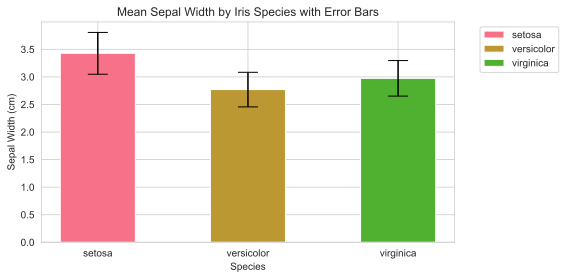

In [7]:
# Focus on sepal width
feature = 'sepal width (cm)'

# Calculate mean and standard deviation for each species
species_stats = {}
for species in iris.target_names:
    mask = iris_df['species'] == species
    mean = iris_df[mask][feature].mean()
    std = iris_df[mask][feature].std()
    species_stats[species] = {'mean': mean, 'std': std}

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 4))

# Create bars for each species
bar_positions = np.arange(len(iris.target_names))
bar_width = 0.5

for i, species in enumerate(iris.target_names):
    ax.bar(bar_positions[i], 
           species_stats[species]['mean'], 
           bar_width, 
           label=species, 
           yerr=species_stats[species]['std'], 
           capsize=10)

# Add labels and title
ax.set_xlabel('Species')
ax.set_ylabel('Sepal Width (cm)')
ax.set_title('Mean Sepal Width by Iris Species with Error Bars')
ax.set_xticks(bar_positions)
ax.set_xticklabels(iris.target_names)

# Add a legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("fig_1.svg")

Notice that in the above figure the error bars for setosa and versicolor barely overlap, meaning that the majority of measurements for one of the flowers is higher than the measurements for the other flower. Thus we can say that on average the flowers have differently sized sepals. 

You will also notice that we of course had three flowers, not two. So this is an opportunity to think about what we would do in the multi-flower situation. In such a case, we can use the generalisation of the t-test which is the One-way ANOVA (Analysis of Variance). It similarly only needs the mean, StdDev, and N of the different distributions. However, it will test whether _any_ of the distributions are significantly different from each other. 

$$
F = \frac{MS_B}{MS_W} = \frac{\sum_{i=1}^k n_i(\bar{X}_i - \bar{X})^2 / (k-1)}{\sum_{i=1}^k\sum_{j=1}^{n_i} (X_{ij} - \bar{X}_i)^2 / (N-k)} 
$$

Here we can see that an ANOVA simply means the mean squared error between the groups divided by the mean squared error within the groups. This is pretty much a generalisation of the t-test we saw above, except its across multiple groups. 

The important detail with an ANOVA is that it says whether any of the groups are different from each other. It does not say _which_ groups are different from each other. Further, it will not tell you immediately whether all of the groups are different, only that there are differences. It similarly gives a score and a p-value. To tell which groups are different we would do a 'post-hoc' test. There are a number of possible tests, with "Bonferroni" and "Tukey's HSD" being common choices. In this case, we will first test whether there is _any_ difference (there should be since we know that there is a difference between setosa and versicolor), then we will look at the pairwise comparisons using Tukey's HSD. 

One-way ANOVA Results:
F-statistic: 49.160
p-value: 0.000

Tukey's HSD Test Results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    setosa versicolor   -0.658    0.0 -0.8189 -0.4971   True
    setosa  virginica   -0.454    0.0 -0.6149 -0.2931   True
versicolor  virginica    0.204 0.0088  0.0431  0.3649   True
------------------------------------------------------------


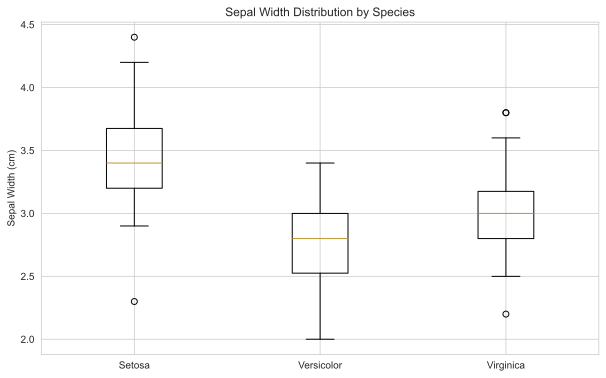

In [8]:

virginica_mask = iris_df['species'] == 'virginica'

# Separate the data into groups
setosa = iris_df[setosa_mask][feature]
versicolor = iris_df[versicolor_mask][feature]
virginica = iris_df[virginica_mask][feature]

# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(setosa, versicolor, virginica)

# Print the results
print("One-way ANOVA Results:")
print(f"F-statistic: {f_statistic:0.3f}")
print(f"p-value: {p_value:0.3f}")

# Perform Tukey's test
tukey_results = pairwise_tukeyhsd(iris_df['sepal width (cm)'], iris_df['species'])

print("\nTukey's HSD Test Results:")
print(tukey_results)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.boxplot([setosa, versicolor, virginica], tick_labels=['Setosa', 'Versicolor', 'Virginica'])
plt.title('Sepal Width Distribution by Species')
plt.ylabel('Sepal Width (cm)')
plt.show()

The above results and visualisations really help to illustrate that what we thought might have been a single normal distribution is in fact the agglomeration of three different distributions all in one. Each of the flowers has its own distribution, represented on the box plot. These plots are in many ways more effective than bar charts with error bars since they show the median value and the range of most common values. 

The HSD results confirm that each of the flowers has a distribution that is different from each other. Note, you can also use `Eta` with this sort of test in order to get a sense of how much variation is per-flower (unshown). 

# Correlation measures 

These tests were comparing distributions to each other but not necessarily _with_ each other. For that we need some way to pair the values. In this case, we use the rows of the data to pair the values. Each row represents a single flower and so the measurements for sepal length and sepal width refer to the same flower. While we know each flower species has some different properties and shapes, we might also be interested in whether these properties vary together. 

With bivariate data we can move a little bit beyond comparing a distribution to a shape. This approach will always be with us since these idealised shapes create assumptions for our tests, but here we are now interested in comparing one distribution to another. So instead of asking how different is this distribution from a normal distribution we can ask, how different is one distribution from another. So thinking in terms of loss we might ask, how much information about one distribution do we gain if we only know the other distribution? 

For this, we would use a correlation (i.e. to suggest the variables are co-related). This is especially interesting in this case, since the correlation for the whole data might show one value, but the correlations per-species show a different value. In order to get a feel for these distributions we can again visualise them. 

$$ 
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

Let’s have a look at what it does. The numerator concerns the variances, that is: how far is each observed value from its expected value. For each entry we look at X and Y together. So if X and Y are both far from the mean their values will amplify each other. But if one is close to the mean and one is far away, they will not amplify each other. If one is above the mean and one is below, the score will be negative. So we add up all these variances for each row. This number could be big or small depending on the underlying distribution. But we want to know how big means the two numbers track each other well or do not track each other well. We do this by dividing by the standard deviation. Whereas each row in the covariance could be positive or negative, each row in the standard deviation is always positive. You can work out on your own why the top number will never be larger than the bottom number, but the point is that the bottom number represents a sort of theoretical maximum. So if the top number is close to that theoretical maximum then the relationship is very informative: x goes up, y goes up or x goes down, y goes down. So when we divide the top number by the bottom number we will get a score from 1 (perfect correlation) through 0 ( no correlation) to -1 (perfect anti-correlation).

We can have a look at that with all the data from the Iris data set in one monster visualisation in Python. Then we can observe the same thing as a series of statistical tests in a second visualisation. Let's render this plot first and then 

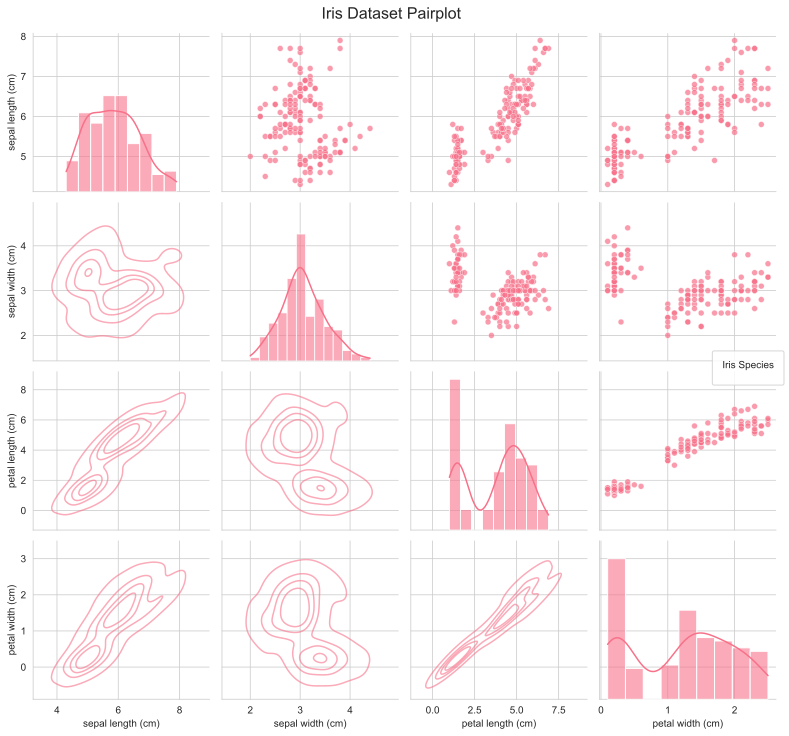

In [12]:
# Create the PairGrid
fig = sns.PairGrid(iris_df, height=2.5)

# Customize the plots
fig.map_upper(sns.scatterplot, s=35, alpha=0.7)
fig.map_lower(sns.kdeplot, levels=5, alpha=0.6)
fig.map_diag(sns.histplot, kde=True, alpha=0.6)

# Customize the legend
fig.add_legend(title="Iris Species", frameon=True, borderpad=1)

# Adjust the layout and add a title
plt.tight_layout()
fig.fig.suptitle("Iris Dataset Pairplot", fontsize=16, y=1.02)

# Show the plot
plt.show()

The plot is very involved, since it draws many subplots, and within each plot we have multiple data points. To that end, it is very information dense. Further, I show the bivariate distribution of the data in two ways in the plots, first as a scatter plot and second as a kernel density estimate. 

A scatterplot uses the points from two series, with one value representing the X and one value representing the Y axis. This can be very useful for many distributions but it has some issues. What if there are many many observations with the same value (all being x = 4 and y = 6, for example). Since these plots would overlap on the screen or figure it is hard to establish this just on a scatterplot. For that reason it is effective to look at a kernel density plot which draws contour rings that highlight where the points are the most common. 

In your own work, you might end up using just a single scatterplot or KDE plot rather than this grid. But in this case, I think the grid is really useful since it shows us how these flowers often have similar values and it also helps us understand where there is some data that is correlated or simply overlapping. I will talk through this plot on the video. 

The diagonals of the pairplot showed a visualisation of the results. However, this does not constitute a statistical test, only a means for getting an intuitive understanding of the data. To look at correlations between the data we can calcuate those with formula. Below I will show first how to calculate the correlation between two variables, and then I will show this on a heatmap for all the variables.  

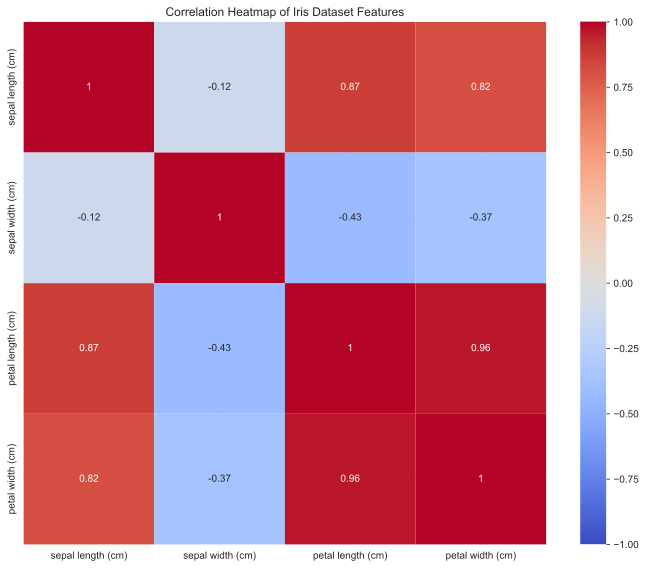

In [13]:
# Select only the numerical columns (excluding 'species')
numerical_cols = iris_df.select_dtypes(include=['float64', 'int64']).columns

# Create the correlation matrix
corr_matrix = iris_df[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Iris Dataset Features')
plt.tight_layout()
plt.show()

In [14]:
# Produce a correlation for all rows
tot_corr = stats.pearsonr(iris_df["sepal width (cm)"],
                          iris_df["petal length (cm)"]) 

print(f"For all data combined:\t corr = {tot_corr[0]:.3f},",
      f"sig = {tot_corr[1]:.3f}")

# Produce correlations for each rows (notice I use .cat.categories, but one could also use .unique())
for flower in iris_df["species"].cat.categories:
    corr = stats.pearsonr(iris_df[iris_df["species"]==flower]["sepal width (cm)"],
                          iris_df[iris_df["species"]==flower]["petal length (cm)"])

    print(f"For species {flower}:\t corr = {corr[0]:.3f},",
          f"sig = {corr[1]:.3f}")

For all data combined:	 corr = -0.428, sig = 0.000
For species setosa:	 corr = 0.178, sig = 0.217
For species versicolor:	 corr = 0.561, sig = 0.000
For species virginica:	 corr = 0.401, sig = 0.004


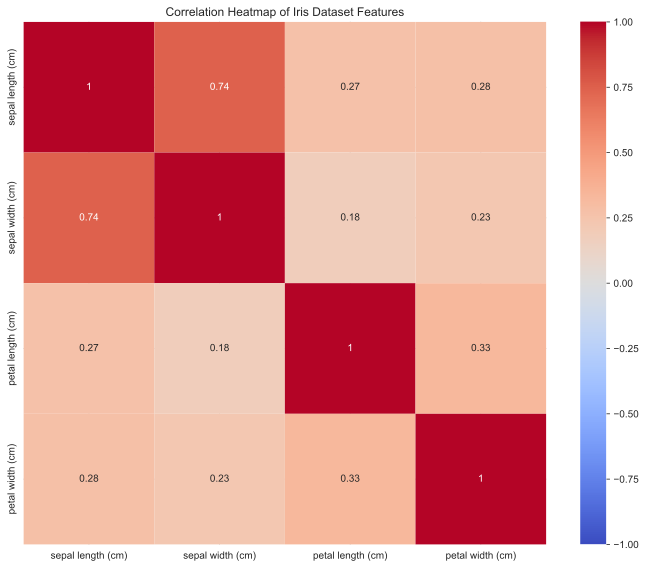

In [15]:
# Select only the numerical columns (excluding 'species')
numerical_cols = iris_df.select_dtypes(include=['float64', 'int64']).columns

# Create the correlation matrix
corr_matrix = iris_df[setosa_mask][numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Iris Dataset Features')
plt.tight_layout()
plt.show()

The formula for a correlation considers the mean value and the variance to be important. But what if we do not have a normally distributed variable? What if we have a handful of houses which are owned by young influencers who made millions on TikTok, whereas most houses follow the overall trend? One way to account for such outliers is to use _non-parametric_ statistics. A parameterised statistic is one that looks at measurements and their values. It accounts for scale. A non-parameterised statistics is one that looks at relative position. It accounts for order (1 < 4 < 100) but not for scale. So its like a correlation except that the variables are treatest as ranging from 1 to N rather than from the min value to the max value. In such cases, a small number of outliers will do less to influence the overall relationship. 

You can observe the practical interest in non-parametric statistics in house prices specifically since we often see reporting of the median house price (i.e. the one in the middle of the distribution) rather than the mean house price (the average which can be sensitive to outliers). 

In [16]:

tot_corr = stats.spearmanr(iris_df["sepal width (cm)"],
                          iris_df["petal length (cm)"]) 

print(f"For all data combined:\t corr = {tot_corr[0]:.3f},",
      f"sig = {tot_corr[1]:.3f}")


for flower in iris_df["species"].cat.categories:
    corr = stats.spearmanr(iris_df[iris_df["species"]==flower]["sepal width (cm)"],
                          iris_df[iris_df["species"]==flower]["petal length (cm)"])

    print(f"For species {flower}:\t corr = {corr[0]:.3f},",
          f"sig = {corr[1]:.3f}")

For all data combined:	 corr = -0.310, sig = 0.000
For species setosa:	 corr = 0.180, sig = 0.211
For species versicolor:	 corr = 0.575, sig = 0.000
For species virginica:	 corr = 0.387, sig = 0.005


In this case, because the data were normally distributed, there wasn't much difference in these results, but in practice, when seeing data that is highly skewed, you will see quite a big difference in these sorts of statistics, as a few highly influential outliers would otherwise exert considerable _leverage_ over the data. 

# Comparing Two Categories of data 

If we have two continuous variables, we would look to correlations or advanced versions thereof. If we have a continuous variable and a categorical variable we can compare the shape or scale of the distributions in a number of ways, such as a t-test. But what if we just have categories? We cannot take the average religion or the average favourite colour, they are simply different categories. However, we can still do some statistics on this, including a very important statistic: Chi-Square. This is a basic and important statistic that asks: given a table with a specific shape we can determine what would be the expected values versus the observed values if the two variables were not related. 

To give an example: let's say we have people from three different countries and we have four flavours of Ice Cream. This would make a table with 12 cells. We do not assume that all the people or all the flavours are distributed equally across the cells. But we do assume that given the distribution of categories on one axis that the expected value is that they will be evenly distributed across the other axis. To explain: 

We have 100 people from "Dataland", 200 from "Sociologo", and 700 from the "United Multidisciplinary Federation [UMF]". We have 250 who like strawberry, 250 who prefer vanilla, 250 who prefer chocolate, and 250 who prefer gelato since it doesn't contain milk. 

This sets up our expected values. See the table below: 

| |Vanilla|Strawberry|Chocolate|Gelato| Row Total|
|----------|-------|----------|---------|------|----|
|Dataland  | | | | |100|
|Sociologo | | | | |200|
|UMF       | | | | |700|
| Col Total         |250 | 250 | 250 | 250 |1000| 

If the values are uncorrelated, then we would observe values like the following: 


| | Vanilla | Strawberry | Chocolate | Gelato | Row Total |
|----------|-------|----------|---------|------|-----------|
| Dataland | 25 | 25 | 25 | 25 | 100 |
| Sociologo | 50 | 50 | 50 | 50 | 200 |
| UMF | 175 | 175 | 175 | 175 | 700 |
| Column Total | 250 | 250 | 250 | 250 | 1000 |

In this case, the row totals represent the number of people from each country and the column totals represent the expected value given the proportions per country and per flavour choice. In reality we probably observe something like this: 

| | Vanilla | Strawberry | Chocolate | Gelato | Row Total |
|----------|-------|----------|---------|------|-----------|
| Dataland | 15 | 40 | 30 | 15 | 100 |
| Sociologo | 80 | 30 | 60 | 30 | 200 |
| UMF | 155 | 180 | 160 | 205 | 700 |
| Column Total | 250 | 250 | 250 | 250 | 1000 |


Which means that some people from some countries have a particular interest in some flavours. For instance, people from Dataland seem to prefer strawberry ice cream more than expected, while those from Sociologo have a stronger preference for vanilla. The UMF population shows a slight preference for gelato. In order to see that more clearly, we might want to _normalise_ our data. In this case, it would be useful to normalise to see the percentages across rows (i.e. so that we know which percentage of people from Dataland prefer which ice cream). In Python this would typically be done with the `pd.crosstab()` function, which takes one Series as rows (often called the explanatory or sometimes 'independent' variable), and one in the column (often called the response or sometimes 'dependent' variable). Typically we would read the percentages within the explanatory variable, not the response variable. However, here we want to know whether these values show more difference than would be expected (see the table above). For this we can use the Chi-square(d) ($\chi^2$) test of independence. 

Chi-square measures the difference between the expected value (all cells have a proportionate number of values, so there's no relation) and the observed value (where some cells might have more or less observations than expected). We sum up all the differences between the observed and the expected. If the value is greater than we would expect by chance, then it would be considered significant. Once again, to determine whether it is significant, we would look up the Chi-square (and degrees of freedom) on a "Chi-Square" distribution (yet another distribution). Again, this is normally something we would do algorithmically. The important part is that we understand that the p-value ends up helping us determine whether given the observed data, the specific spread of values is something we would expect to find by chance if the two values were uncorrelated.

$$
\chi^2 = \sum_{i=1}^n \frac{(O_i - E_i)^2}{E_i}
$$

These values should lead to a significant chi-square test result, indicating that there is likely a relationship between country of origin and ice cream flavor preference. The differences between the expected and observed frequencies are substantial enough to suggest that the variables are not independent, meaning that indeed, to a limited extent, Country can predict flavour preference (or we might say Country has some explanatory power). 

Below I'll show first the chi-square test of independence with this data. I've tuned the values so that I can be confident that the Chi-square value is significant, but in reality we may or may not find a significant value.

This is also our first opportunity to see a different data structure in Python that is commonly used in analysis: the numpy array. An array in Python is multidimensional collection of numbers. Unlike a DataFrame it does not hold different kinds of objects, and nor does it have an index. It is simply a rectangular collection of numbers. 2-dimensional arrays usually represent rows and columns of data, but can also represent matrices, such as the matrix of correlations above that were used to create the heatmap. The scipy stats function takes both DataFrame / Series objects from pandas and the simpler but more efficient numpy array as input.

In [17]:
import numpy as np
from scipy.stats import chi2_contingency

# Create the observed frequency table as a NumPy array
observed = np.array([
    [15, 40, 30, 15],
    [80, 30, 60, 30],
    [155, 180, 160, 205]
])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(observed)

print(f"Chi-squared statistic: {chi2:.3f}")
print(f"p-value: {p_value:.3f}")
print(f"Degrees of freedom: {dof}")

Chi-squared statistic: 62.857
p-value: 0.000
Degrees of freedom: 6


# Now turning to Stack Exchange data 

Now it's your turn to apply these skills to the Stack Exchange data. Once again, we will see that the data in the real world is a lot more messy than either this toy data or a classic but canned data set for training such as the Iris data. But in general, we do not see very strong relationships between the data. The point is whether we see enough of a relationship to suggest that this did not occur by chance. 

For the first question we are asking you to explore the relationship between two variables. You should first plot the distributions jointly. Whereas this lecture used the involved pairplot for all the variables, you would likely make use of a `scatterplot` or `jointplot` which will show both a scatter plot and the individual distributions. Then based on the shape posit whether it would be more appropriate to use a parametric or non-parametric correlation. Note that data do not need to be perfectly normal to warrant a correlation, only that as it departs from normal it will make the ability to detect a robust relationship more difficult. Now in the class I have shown Pearson and Spearman, but you may already be aware of more sophisticated approaches to considering the relationship. You are welcome to use those herein as well to share within your group at the beginning of the Friday lab. 

You will likely want to also facet the data in some way (such as by question or answer, only including a certain tag or phrase in the text). Try to find a creative way to consider operationalising a variable or filtering the data. For example, instead of simply using Score, why not consider the length of the body text or the number of tags? As the class proceeds we will see both increasingly interesting ways of probing such data as well as coming up with these measures (calling them features). 

We ask that you do two analyses: One that features a Categorical variable and one that features two numeric variables. For each, posit why a relationship would be plausible, do the visualisation, some statistical test based on your sense of the shape of the data, and interpret the results.  